Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

---



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline # используем пайплайны для удобства
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from numpy import arange

# Преобразуйте данные:
a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
b. закодируйте категориальные переменные числовыми значениями по необходимости.
Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

In [ ]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [ ]:
data.describe(include='all')

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
count,1.153800e+04,11538,11538,11538,11537,11208.000000,10879.000000,11538,11538.000000,11538.000000,11538.000000
unique,NaN,11517,207,2,5595,NaN,NaN,28,NaN,NaN,NaN
top,NaN,Ahmed Mohamed,USA,male,2/18/93,NaN,NaN,athletics,NaN,NaN,NaN
freq,NaN,2,567,6333,9,NaN,NaN,2363,NaN,NaN,NaN
mean,4.999885e+08,NaN,NaN,NaN,NaN,1.766282,72.068205,NaN,0.057722,0.056769,0.061016
std,2.908648e+08,NaN,NaN,NaN,NaN,0.112719,16.177334,NaN,0.255910,0.239147,0.243320
min,1.834700e+04,NaN,NaN,NaN,NaN,1.210000,31.000000,NaN,0.000000,0.000000,0.000000
25%,2.450997e+08,NaN,NaN,NaN,NaN,1.690000,60.000000,NaN,0.000000,0.000000,0.000000
50%,5.002011e+08,NaN,NaN,NaN,NaN,1.760000,70.000000,NaN,0.000000,0.000000,0.000000
75%,7.539874e+08,NaN,NaN,NaN,NaN,1.840000,81.000000,NaN,0.000000,0.000000,0.000000


In [ ]:
data.isna().sum()

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [ ]:
# удаляем строки с пропусками
data=data.dropna()

За целевую переменную примем "sex".


In [ ]:
# посмотрим, насколько сбалансированы данные
print(data['sex'].value_counts())

male      5862
female    4996
Name: sex, dtype: int64


Удалим признаки, которые не имеют ценности для модели: id, имя, национальность, дата рождения, вид спорта

In [ ]:
data=data.drop(['id', 'name', 'nationality', 'dob', 'sport'], axis=1)
data.head()

,sex,height,weight,gold,silver,bronze
0,male,1.72,64.0,0,0,0
1,female,1.68,56.0,0,0,0
2,male,1.98,79.0,0,0,1
3,male,1.83,80.0,0,0,0
4,male,1.81,71.0,0,0,0


In [ ]:
data.isna().sum()

sex       0
height    0
weight    0
gold      0
silver    0
bronze    0
dtype: int64

Формируем набор признаков и целевую переменную

In [ ]:
data['sex'].unique()

array(['male', 'female'], dtype=object)

In [ ]:
data['gold'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
data['silver'].unique()

array([0, 1, 2])

In [ ]:
data['bronze'].unique()

array([0, 1, 2])

In [ ]:
selectedColumns = data[data.columns[1:]]

In [ ]:
# столбцы с категориальными переменными переводим в значения 0 и 1
X = pd.get_dummies (selectedColumns, columns = ['gold','silver','bronze'])

In [ ]:
print('Преобразовали категориальные признаки.')
X.head()

Преобразовали категориальные признаки.


,height,weight,gold_0,gold_1,gold_2,gold_3,gold_4,gold_5,silver_0,silver_1,silver_2,bronze_0,bronze_1,bronze_2
0,1.72,64.0,1,0,0,0,0,0,1,0,0,1,0,0
1,1.68,56.0,1,0,0,0,0,0,1,0,0,1,0,0
2,1.98,79.0,1,0,0,0,0,0,1,0,0,0,1,0
3,1.83,80.0,1,0,0,0,0,0,1,0,0,1,0,0
4,1.81,71.0,1,0,0,0,0,0,1,0,0,1,0,0


<p>LabelEncoder ставит в соответствие значению пола(целевая переменная) 0 и 1 </p>

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit( data['sex'])

LabelEncoder()

In [ ]:
le.classes_

array(['female', 'male'], dtype=object)

In [ ]:
le.transform( ['female', 'male']) # пример расшифровки

array([0, 1])

In [ ]:
# записываем в таргетную переменную y преобразованный столбец sex

Y = pd.Series (le.transform(data['sex']))
Y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int64

Разбиваем данные на обучающую и тестовую выборки в соотношении 80 / 20

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,random_state = 0)

In [ ]:
X_test

,height,weight,gold_0,gold_1,gold_2,gold_3,gold_4,gold_5,silver_0,silver_1,silver_2,bronze_0,bronze_1,bronze_2
7210,1.89,78.0,1,0,0,0,0,0,1,0,0,1,0,0
2257,1.71,60.0,1,0,0,0,0,0,1,0,0,1,0,0
181,1.80,73.0,1,0,0,0,0,0,1,0,0,1,0,0
4425,1.95,105.0,1,0,0,0,0,0,1,0,0,1,0,0
1575,1.58,86.0,1,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,1.80,67.0,1,0,0,0,0,0,1,0,0,1,0,0
4992,1.70,76.0,1,0,0,0,0,0,1,0,0,1,0,0
10851,1.73,64.0,1,0,0,0,0,0,1,0,0,1,0,0
3141,1.67,58.0,1,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
Y_test

6798     1
2124     0
159      1
4148     1
1478     1
        ..
2055     0
4687     1
10204    0
2952     0
10285    1
Length: 2172, dtype: int64

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train, Y_train)

In [ ]:
predictions = model.predict_proba(X_test) # по умолчанию в методах predict стоит отсечка в 0.5. Отсечка -это вероятноть принадлежности к 0 или 1 классу
fpr, tpr, thresh = roc_curve(Y_test, predictions[:,1])

In [ ]:
predictions

array([[0.1750249 , 0.8249751 ],
       [0.70470091, 0.29529909],
       [0.3389288 , 0.6610712 ],
       ...,
       [0.60754321, 0.39245679],
       [0.77621321, 0.22378679],
       [0.01502512, 0.98497488]])

In [ ]:
model.predict(X_test)

array([1, 0, 1, ..., 0, 0, 1])

# Обучение модели

Визуализируем вероятности быть 1 классом, по оси абсцисс порядковый номер объектов, а по оси ординат вероятность быть первым классом и раскрасим их в зависимости от истинной метки класса.   
Оранжевые - объекты 0 класса (female), синие - объекты 1 класса (male).

При этом низкой вероятностью обладают объекты как первого класса, так и нулевого.

In [ ]:
import  matplotlib.pyplot as plt

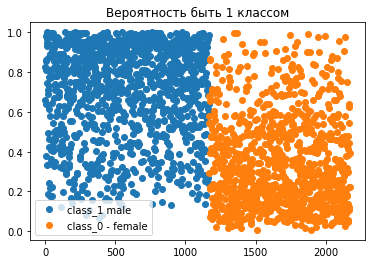

In [ ]:
class_1 = predictions[:, 1][Y_test == 1]
class_0 = predictions[:, 1][Y_test == 0]

plt.scatter(np.arange(len(class_1)), class_1, label='class_1 male')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0 - female')
plt.title('Вероятность быть 1 классом')
plt.legend();

## Стандартная отсечка 0.5

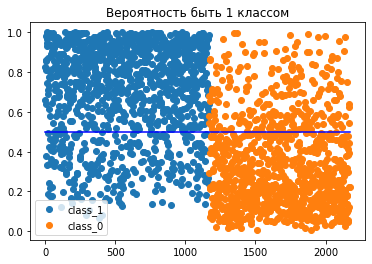

In [ ]:
threshold = 0.5
class_1 = predictions[:, 1][Y_test == 1]
class_0 = predictions[:, 1][Y_test == 0]

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(predictions[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

Чтобы получить метрику ROC-AUC, нужно оперировать двумя метриками, которые строятся на матрице ошибок - это TPR и FPR.


**TPR (True Positive Rate, доля верных срабатываний)** - отношение числа верных срабатываний к размеру положительного класса:

$$TPR = \frac{TP}{TP+FN}$$

то есть TPR по сути представляет из себя полноту - сколько раз модель правильно нашла целевой класс среди тех людей, которые действительно являются им.

Данная метрика в идеале должна стремиться к единице.


**FPR (False Positive Rate, доля ложных срабатываний)** - отношение числа ложных срабатываний к общему размеру отрицательного класса:
$$FPR = \frac{FP}{FP+TN}$$

аналог полноты  для ошибок - сколько раз модель ошибочно нашла целевой класс среди всех людей нецелевого класса.

Данная метрика в идеале должна стремиться к нулю.


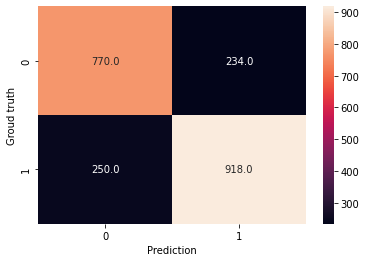

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


pred = np.where(predictions[:, 1] >= threshold, 1, 0)

cm = confusion_matrix(Y_test, pred)
f = sns.heatmap(cm, annot=True,fmt=".1f")
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

## Поднимаем отсечку

Для увеличения чистоты классификации (уменьшения FPR), нужно поднимать отсечку. В этом случае  ошибка False Positive убирается, т.к. предсказанная вероятность теперь будет меньше. А значит больше не будет ошибок ложного срабатывания и FPR будет стремиться к нулю.

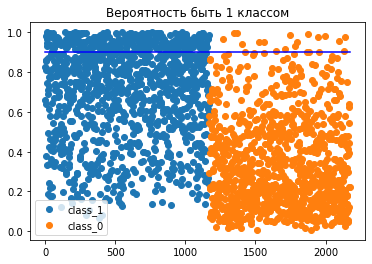

In [ ]:
threshold = 0.9

class_1 = predictions[:, 1][Y_test == 1]
class_0 = predictions[:, 1][Y_test == 0]

pred = np.where(predictions[:, 1] >= threshold, 1, 0)

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(predictions[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

TPR 0.261986301369863
FPR 0.018924302788844622


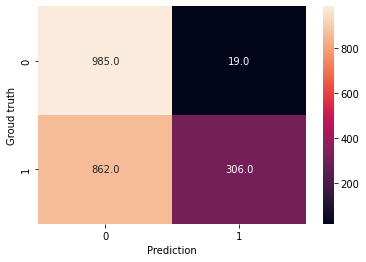

In [ ]:
cm = confusion_matrix(Y_test, pred)
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
print('TPR', TP / (TP + FN))
print('FPR', FP / (FP + TN))

f = sns.heatmap(cm, annot=True, fmt=".1f")
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

## Снижаем отсечку

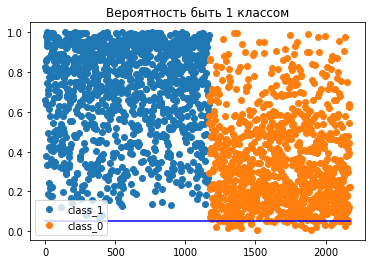

In [ ]:
threshold = 0.05

class_1 = predictions[:, 1][Y_test == 1]
class_0 = predictions[:, 1][Y_test == 0]

pred = np.where(predictions[:, 1] >= threshold, 1, 0)

plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(predictions[:, 1])], [threshold, threshold], c='b')
plt.title('Вероятность быть 1 классом')
plt.legend();

TPR 1.0
FPR 0.9741035856573705


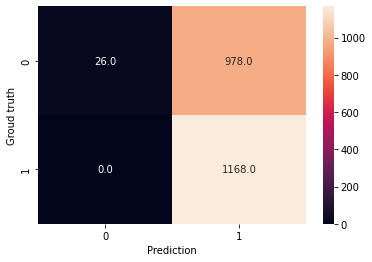

In [ ]:
cm = confusion_matrix(Y_test, pred)
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
print('TPR', TP / (TP + FN))
print('FPR', FP / (FP + TN))

f = sns.heatmap(cm, annot=True, fmt=".1f")
plt.ylabel('Groud truth')
plt.xlabel('Prediction');

#Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

In [ ]:
# Кривая ROC показывает нам взаимосвязь между показателем ложных положительных результатов (FPR) и
# истинно положительным показателем (TPR) для разных пороговых значений.

In [ ]:
fpr_, tpr_, thresh = roc_curve(Y_test, predictions[:,1])

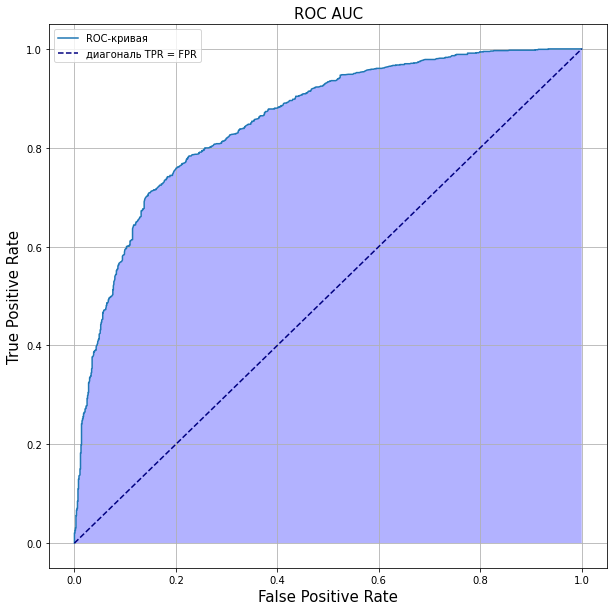

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(fpr_, tpr_, label = 'ROC-кривая')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'диагональ TPR = FPR')
plt.fill_between(fpr_, tpr_, facecolor='blue', alpha=0.3)
plt.title('ROC AUC', fontdict={'fontsize': 15})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 15})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 15})
plt.legend( loc = 0 )
plt.grid()
plt.show()

# Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [ ]:
roc_auc_score(Y_test, predictions[:, 1])

0.8536551567701796

# Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [ ]:
tp = 0 # True positive - количество верно классифицированных моделью положительных примеров (так называемые истинно положительные случаи)
fp = 0 # False positive - количество верно классифицированных отрицательных примеров (истинно отрицательные случаи)
fn = 0 # False negative - количество положительных примеров, классифицированных моделью как отрицательные (ошибки первого рода)
tn = 0 # True negative - количество отрицательных примеров, классифицированных как положительные (ошибки второго рода)

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], Y_test ):
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0

    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1

    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [ ]:
tp, fp, fn, tn

(918, 234, 250, 770)

In [ ]:
tpr = tp / (tp + fn) # recall для целевого класса на отсечке 0.5
tpr

0.785958904109589

In [ ]:
fpr = fp / (fp + tn) # recall ошибок на отсечке 0.5 небольшой
fpr

0.23306772908366533

In [ ]:
precision = tp / (tp + fp) # доля правильно предсказанных среди причисленных моделью к категории 1
precision

0.796875

# Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

Для каждого значения порога отсечения, изменяемого с шагом dх (например, 0,01) от 0 до 1, рассчитывают значения чувствительности и специфичности (в качестве альтернативы можно просто взять каждое последующее значение примера в выборке).

In [ ]:
thresholds = arange(0, 1, 0.01)
fprs = []
tprs = []
prs = []
res = []
for threshold in thresholds:
    tp_ = 0 # True positive
    fp_ = 0 # False positive
    fn_ = 0 # False negative
    tn_ = 0 # True negative
    for predicted_prob, actual in zip( predictions[:, 1], Y_test ):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp_ += 1
            else:
                fp_ += 1

        else:
            if actual == 1:
                fn_ += 1
            else:
                tn_ += 1
    tpr1 = tp_/(tp_ + fn_) # чувствительность
    fpr1 = fp_/(fp_ + tn_) # специфичность
    precision = tp_/(tp_ + fp_) # доля правильно предсказанных среди причисленных моделью к категории 1
    recall = tpr1 #доля правильно предсказанных среди категории 1
    fprs.append(fpr1)
    tprs.append(tpr1)
    prs.append(precision)
    res.append(recall)

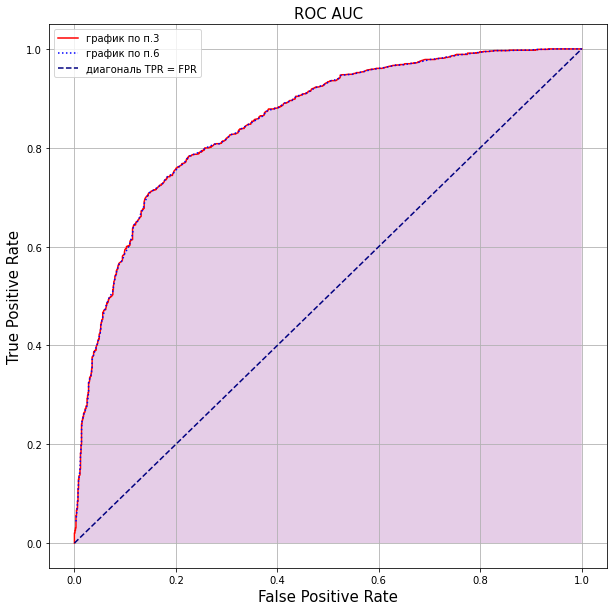

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(fpr_, tpr_, color='red', label = 'график по п.3')
plt.plot(fprs, tprs, color='blue', linestyle=':', label = 'график по п.6')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'диагональ TPR = FPR' )
plt.fill_between(fpr_, tpr_, facecolor='red', alpha=0.1)
plt.fill_between(fprs, tprs, facecolor='blue', alpha=0.1)
plt.title('ROC AUC', fontdict={'fontsize': 15})
plt.legend( loc = 0 )
plt.grid()
plt.xlabel('False Positive Rate', fontdict={'fontsize': 15})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 15})
plt.show()

Выводы: При визуальной оценке ROC-кривых расположение их относительно друг друга указывает на их сравнительную эффективность. Кривая, расположенная выше и левее, свидетельствует о большей предсказательной способности модели. На нашем графику ROC-кривые практически слились, и их визуальное сравнение затруднено. В этом случае для оценки эффективности модели можно использовать площадь под кривой (AUC, Area Under Curve).
Диагональная линия соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов.

# Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

In [ ]:
# Кривая PR показывает нам взаимосвязь между показателем Precision (точность) и Recall (полнота) для разных пороговых значений.
# Модель тем лучше, чем выше площадь подкривой.

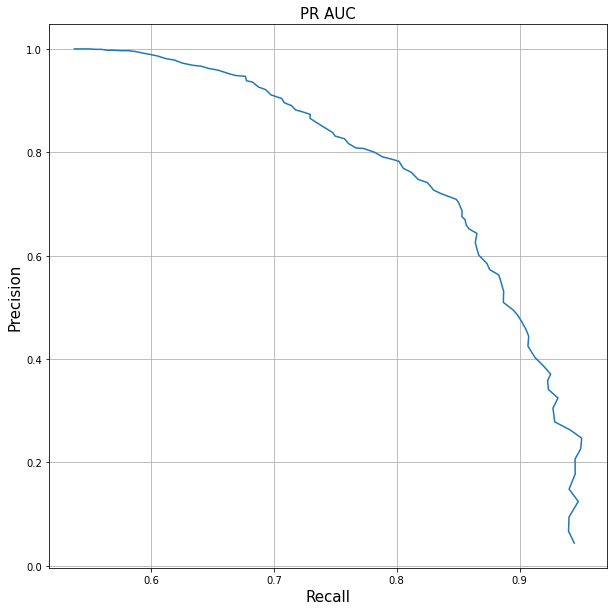

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(prs, res)
plt.title('PR AUC', fontdict={'fontsize': 15})
plt.xlabel('Recall', fontdict={'fontsize': 15})
plt.ylabel('Precision', fontdict={'fontsize': 15})
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
# площадь под кривой
average_precision_score( Y_test, predictions[:, 1] )

0.8625388348387489

результат по площади хороший

# Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [ ]:
# считаем площадь через функцию 'auc' (area under curve) из 'sklearn'
from sklearn.metrics import auc

auc(fprs, tprs)

0.8534543333515254

Значение ROC-AUC метрики, подсчитанное для тестового значения целевой переменной с помощью функции sklearn.metrics.roc_auc_score, незначительно отличается (лучше) от метрики ROC-AUC, подсчитанной "вручную" напрямую для auc

In [ ]:
print(roc_auc_score(Y_test, predictions[:, 1]))
print(auc(fprs, tprs))


0.8536551567701796
0.8534543333515254


# Сформулируйте выводы по проделанной работе:

## как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

Исходя из полученного графика ROC, модель получилась с хорошей предсказательной способностью.

Для идеального классификатора график ROC-кривой проходит через верхний левый угол, где доля истинно положительных случаев составляет 100 % или 1,0 (идеальная чувствительность), а доля ложно положительных примеров равна нулю. Поэтому чем ближе кривая к верхнему левому углу, тем выше предсказательная способность модели. Наоборот, чем меньше изгиб кривой и чем ближе она расположена к диагональной прямой, тем менее эффективна модель. Диагональная линия соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов.

В дополнительной литературе есть экспертная шкала для значений AUC:

Интервал AUC	Качество модели

0.9–1.0	Отличное

0.8–0.9	Очень хорошее

0.7–0.8	Хорошее

0.6–0.7	Среднее

0.5–0.6	Неудовлетворительное

Согласно этой шкале, модель получилась очень хорошего качества.

Модель обладает хорошей чувствительностью и приемлемой специфичностью

In [ ]:
print('Качество модели:', roc_auc_score(Y_test, predictions[:, 1]))
print('Чувствительность:', tpr)
print('Специфичность:', fpr)

Качество модели: 0.8536551567701796
Чувствительность: 0.785958904109589
Специфичность: 0.23306772908366533
